In [11]:
from synapse import Action, Cubic
from typing import List, Tuple
import numpy as np
import random

def sample_cubics(n: int, delta: float) -> Tuple[float, List[Cubic]]:
    num_cubics = n
    start_position = random.uniform(0, 1)
    current_position = start_position
    current_cubics = []
    for _ in range(num_cubics):
        permissible_range = [-current_position, 1-current_position]
        def generate_cubic():
            return Cubic(
                m=random.uniform(-delta, delta),
                n=random.uniform(-delta, delta),
                a=random.uniform(*permissible_range),
            )
        
        cubic = generate_cubic()
        results = cubic(np.linspace(0, 1, 10))
        min_results = np.min(results)
        max_results = np.max(results)

        while min_results + current_position < 0 or max_results + current_position > 1:
            cubic = generate_cubic()
            results = cubic(np.linspace(0, 1, 10))
            min_results = np.min(results)
            max_results = np.max(results)

        current_position += cubic(1)
        current_cubics.append(cubic)
    
    return start_position, current_cubics

In [12]:
def cubics_to_points(x_start: float, y_start: float, x_cubics: List[Cubic], y_cubics: List[Cubic], fps=2, x_points: np.ndarray=np.linspace(0, 1, 400)) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    previous_last = (x_start, y_start)

    all_poly_x = []
    all_poly_y = []

    for (xc, yc) in zip(x_cubics, y_cubics):
        x_dense = x_points
        y_cubic_of_xcoord = xc(x_dense)
        y_cubic_of_ycoord = yc(x_dense)

        all_poly_x.extend(y_cubic_of_xcoord + previous_last[0])
        all_poly_y.extend(y_cubic_of_ycoord + previous_last[1])

        previous_last = (xc(1) + previous_last[0],
                        yc(1) + previous_last[1])

    # t = list(range(len(all_poly_x)))
    t = np.arange(0, len(all_poly_x)/fps, 1/fps)

    return t, np.array(all_poly_x), np.array(all_poly_y)

(0.0, 480.0)

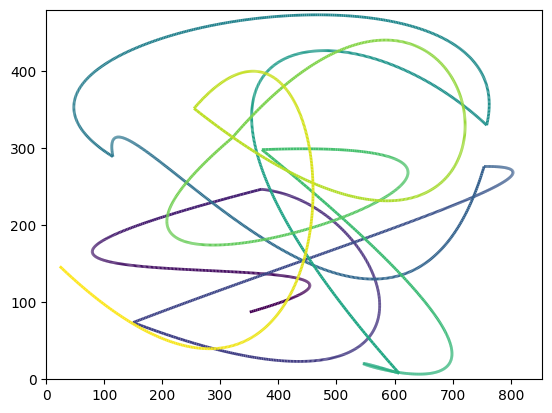

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from io import BytesIO
from PIL import Image

screen_size = (854, 480)
t = np.array(t)
x = np.array(all_poly_x) * screen_size[0]
y = np.array(all_poly_y) * screen_size[1]
norm = plt.Normalize(t.min(), t.max())
colors = cm.viridis(norm(t))

# Build segments between consecutive points
pts = np.stack([x, y], axis=1)
segs = np.concatenate([pts[:-1,None], pts[1:,None]], axis=1)

# Create a LineCollection, one segment per time step
lc = LineCollection(segs, colors=colors[:-1], linewidth=2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.set_xlim(0, screen_size[0])
ax.set_ylim(0, screen_size[1])

# ax.set_aspect('equal', 'box')
# ax.axis('off')                      # <-- turn off axes
# fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # no margins

# # Render to an in-memory PNG
# buf = BytesIO()
# fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
# plt.close(fig)
# buf.seek(0)

# # # Load into Pillow
# img = Image.open(buf)

# # And if you want a NumPy array:
# img_arr = np.array(img)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image, ImageDraw

from synapse.video_loader.video import smart_resize

def generate_image_from_segments(t: np.ndarray, x: np.ndarray, y: np.ndarray, screen_size: tuple[float, float]) -> Image:
    x = x * screen_size[0]
    y = y * screen_size[1]
    norm = plt.Normalize(t.min(), t.max())
    colors = cm.viridis(norm(t))

    # pick a colormap and normalize t to [0,1]
    norm = (t - t.min()) / (t.max() - t.min())
    colors = (cm.viridis(norm)[:, :3] * 255).astype(np.uint8)

    # make a blank RGBA image
    scale_factor = 8
    upsampled = (screen_size[0] * scale_factor, screen_size[1] * scale_factor)
    img = Image.new("RGBA", upsampled, (255,255,255,255))
    draw = ImageDraw.Draw(img)

    for i in range(len(x)-1):
        p0 = (x[i]*scale_factor,   y[i]*scale_factor)
        p1 = (x[i+1]*scale_factor, y[i+1]*scale_factor)
        draw.line([p0, p1], fill=tuple(colors[i]), width=int(4.3*scale_factor))

    img_small = img.resize(screen_size, Image.LANCZOS)
    return img_small

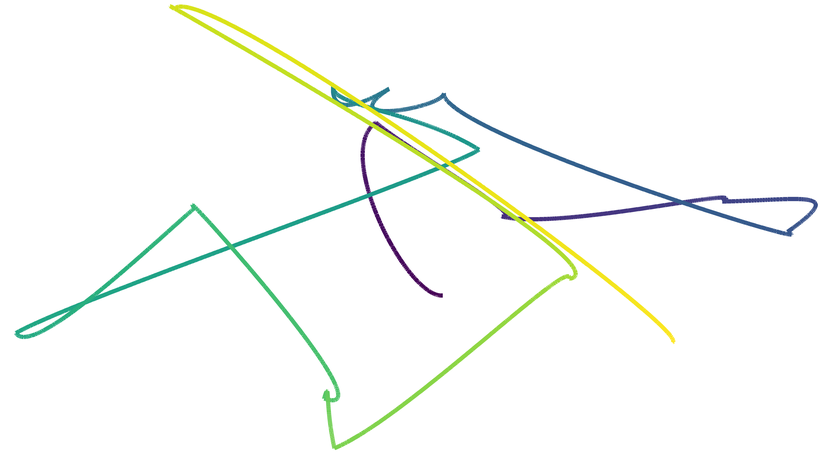

In [77]:
SCREEN_SIZE = smart_resize(854, 480, factor=28, min_pixels=0, max_pixels=854*480)
n_segments = 15
delta = 0.3
(x_start, x_cubics), (y_start, y_cubics) = sample_cubics(n_segments, delta), sample_cubics(n_segments, delta)
t, all_poly_x, all_poly_y = cubics_to_points(x_start, y_start, x_cubics, y_cubics)
img = generate_image_from_segments(t, all_poly_x, all_poly_y, SCREEN_SIZE)
img

In [578]:
overlay = Image.open('../../assets/default.png').convert('RGBA')

def create_video_array(x_start: float, y_start: float, x_cubics: List[Cubic], y_cubics: List[Cubic]):
    ts, all_poly_x, all_poly_y = cubics_to_points(x_start, y_start, x_cubics, y_cubics, fps=4, x_points=np.array([0, 0.5]))
    imgs = []
    timestamps = []
    for i, (time, x, y) in enumerate(zip(ts, all_poly_x, all_poly_y)):
        new_img = img.copy()
        new_img.paste(overlay, (int(x * SCREEN_SIZE[0]), int(y * SCREEN_SIZE[1])), overlay)
        imgs.append(new_img)
        timestamps.append(time)

    img_array = np.array([imgs[0]]+imgs)[:, :, :, :3]
    time_array = np.array(timestamps)

    return time_array, img_array

In [579]:
times, imgs = create_video_array(x_start, y_start, x_cubics, y_cubics)

In [599]:
i = -1

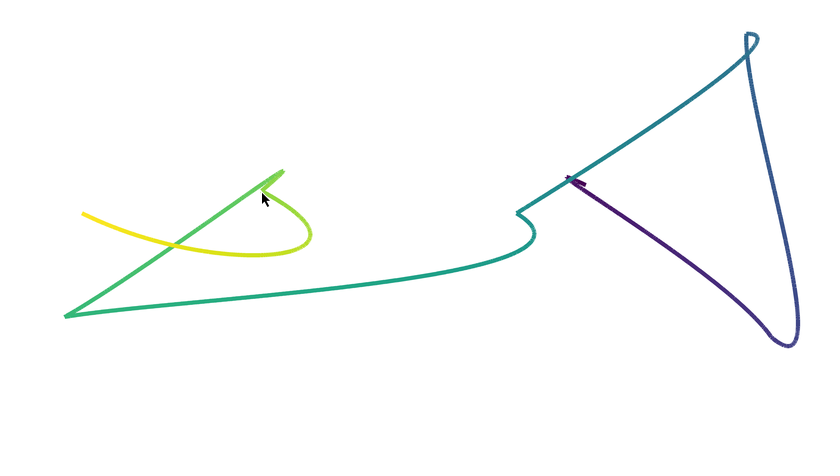

In [611]:
i += 1
Image.fromarray(imgs[i])

In [447]:
x_cubics

[Cubic(m=0.4192874759490953, n=0.043754777575124915, a=0.1314977533909334),
 Cubic(m=-0.031061095279514395, n=-0.1350039980861657, a=-0.7150942386908548),
 Cubic(m=0.22668089638922895, n=0.24358940567849074, a=0.020048000748853045),
 Cubic(m=-0.3772101134595526, n=-0.14635569645392865, a=0.5278685190351984),
 Cubic(m=-0.03949039273288457, n=-0.37997255998874846, a=0.15991315911632742),
 Cubic(m=0.4552837714803063, n=0.40395327782676826, a=0.027904891442541713)]

(840, 476)

In [95]:
from synapse.video_loader.read_frames import fetch_frames_from_zarr

In [102]:
i = -1

In [113]:
i += 1
frames = await fetch_frames_from_zarr(f"gs://induction-labs/jonathan/synth/cursor_follow_v0/sample_{i}.zarr", (0, 2))
Image.fromarray(frames[0].transpose(1, 2, 0))

ValueError: NOT_FOUND: Error opening "zarr3" driver: Metadata at gs://induction-labs/jonathan/synth/cursor_follow_v0/sample_10.zarr/zarr.json does not exist [tensorstore_spec='{\"context\":{\"cache_pool\":{},\"data_copy_concurrency\":{},\"gcs_request_concurrency\":{},\"gcs_request_retries\":{},\"gcs_user_project\":{}},\"driver\":\"zarr3\",\"kvstore\":{\"bucket\":\"induction-labs\",\"driver\":\"gcs\",\"path\":\"jonathan/synth/cursor_follow_v0/sample_10.zarr/\"}}'] [source locations='tensorstore/driver/kvs_backed_chunk_driver.cc:1320\ntensorstore/driver/driver.cc:116']

In [1]:
import run

In [2]:
time, imgs, x_cubics, y_cubics = run.video

In [3]:
from synapse.video_loader.typess import FramesMetadata, VideoResolution, VideoMetadata, StreamMetadata
from synapse.video_loader.video import smart_resize
from fractions import Fraction

SCREEN_SIZE = smart_resize(854, 480, factor=28, min_pixels=0, max_pixels=854 * 480)
output_meta = FramesMetadata(
    fps=Fraction(4),
    total_frames=imgs.shape[0],
    resolution=VideoResolution(
        width=SCREEN_SIZE[0],
        height=SCREEN_SIZE[1],
    )
)
input_meta = VideoMetadata(
    start_pts=0,
    duration=imgs.shape[0],
    time_base=Fraction(1, 4),
    **output_meta.model_dump()
)
stream_metadata = StreamMetadata(
    input_video=input_meta,
    output_video=output_meta,
    output_frames_per_chunk=imgs.shape[0]
)

In [4]:
import tensorstore as ts
from synapse.video_loader.zarr_utils import (
    ZarrArrayAttributes,
    append_batch,
    create_zarr_array,
)

shape = (output_meta.total_frames, 3, output_meta.resolution.height, output_meta.resolution.width)
zarr_array = await create_zarr_array(
            ZarrArrayAttributes(
                chunk_shape=shape,
                shape=shape,
                dtype=ts.uint8,
                path="gs://induction-labs/jonathan/synth/testing2.zarr",
                metadata={
                    "stream": stream_metadata.model_dump(),
                },
            ),
        )

I0627 14:37:48.990043 1172208 google_auth_provider.cc:149] Using credentials at /Users/jonathan/.config/gcloud/application_default_credentials.json
I0627 14:37:48.990379 1172208 google_auth_provider.cc:156] Using OAuth2 AuthProvider


In [5]:
imgs.shape

(13, 476, 840, 3)

In [ ]:
import torch
imgs_zarr_trans = torch.from_numpy(imgs).permute(0, 3, 1, 2)

await append_batch(zarr_array, imgs_zarr_trans, 0)

In [8]:
imgs_zarr_trans.shape

torch.Size([13, 3, 476, 840])

In [10]:
13*3*476*840

15593760

In [7]:
imgs.shape

(13, 476, 840, 3)

In [ ]:
text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."""

In [28]:
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFont

# QWERTY proximity map for realistic inter-key timing
_POS = {**{c.lower(): (i, 0) for i, c in enumerate("QWERTYUIOP")},
        **{c.lower(): (i, 1) for i, c in enumerate("ASDFGHJKL")},
        **{c.lower(): (i, 2) for i, c in enumerate("ZXCVBNM")}}
_MAX_DIST = (9**2 + 2**2) ** 0.5

def _key_dist(a, b):
    a, b = a.lower(), b.lower()
    if a in _POS and b in _POS:
        dx = _POS[a][0] - _POS[b][0]
        dy = _POS[a][1] - _POS[b][1]
        return ((dx*dx + dy*dy) ** 0.5) / _MAX_DIST
    return 1.0

# map space for logging
def _map_key(ch):
    return "space" if ch == " " else ch

# symbols that require shift and their base keys
_SHIFT_KEY_MAP = {
    '!': '1', '@': '2', '#': '3', '$': '4', '%': '5',
    '^': '6', '&': '7', '*': '8', '(': '9', ')': '0',
    '_': '-', '+': '=', '{': '[', '}': ']', '|': '\\',
    ':': ';', '"': "'", '<': ',', '>': '.', '?': '/'
}

def generate_typing_video(
    text: str,
    fps: int = 10,
    speed: float = 3.0,
    frame_size=(480, 854),
    font_path=None,
    font_size=24,
    random_position: bool = True,
    seed=None,
    # timing parameters (µ, σ for log-normal)
    hold_mu=-2.0, hold_sigma=0.5,
    space_hold_mu=-2.5, space_hold_sigma=0.4,
    gap_mu=-1.5, gap_sigma=0.6,
    post_space_gap=2.0,
    min_gap_factor=0.5
):
    """
    Returns:
      video: np.ndarray of shape (n_frames, H, W, 3)
      key_logs: list of {"action": {...}, "timestamp": ...} dicts
      frame_times: list of frame timestamps
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    H, W = frame_size
    font = ImageFont.truetype(font_path, font_size) if font_path else ImageFont.load_default()

    # Measure full-text bounding box
    tmp = Image.new("RGB", (W, H))
    draw_tmp = ImageDraw.Draw(tmp)
    bx = draw_tmp.textbbox((0, 0), text, font=font)
    text_w, text_h = bx[2] - bx[0], bx[3] - bx[1]

    # Choose random origin so text stays fully inside
    if random_position:
        x0 = random.randint(0, max(0, W - text_w))
        y0 = random.randint(0, max(0, H - text_h))
    else:
        x0, y0 = 10, 10

    # 1) Simulate press/release events
    raw_events = []     # (time, key, is_down)
    release_times = []
    t = 0.0
    prev = None

    for ch in text:
        key_name = _map_key(ch)
        needs_shift = ch.isupper() or ch in _SHIFT_KEY_MAP

        # -- press phase --
        if needs_shift:
            raw_events.append((t, "shift", True))
            raw_events.append((t, ch,    True))
        else:
            raw_events.append((t, key_name, True))

        # -- compute hold duration --
        mu, sig = (space_hold_mu, space_hold_sigma) if ch == " " else (hold_mu, hold_sigma)
        raw = random.lognormvariate(mu, sig)
        hold = max(0.02, min(raw, 1.0)) / speed
        key_rel = t + hold

        # -- release phase --
        if ch.isupper():
            # uppercase: shift up halfway, then lowercase key up at end
            shift_rel = t + hold * 0.5
            raw_events.append((shift_rel, "shift", False))
            raw_events.append((key_rel, ch.lower(), False))
            release_times.append(key_rel)
        elif ch in _SHIFT_KEY_MAP:
            # symbol: shift up halfway, then base key up
            shift_rel = t + hold * 0.5
            raw_events.append((shift_rel, "shift", False))
            raw_events.append((key_rel, _SHIFT_KEY_MAP[ch], False))
            release_times.append(key_rel)
        else:
            raw_events.append((key_rel, key_name, False))
            release_times.append(key_rel)

        t += hold

        # -- inter-key gap --
        if ch != text[-1]:
            base = random.lognormvariate(gap_mu, gap_sigma)
            if ch == " ":
                base *= post_space_gap
            base = max(0.03, min(base, 1.5)) / speed
            factor = min_gap_factor + (1 - min_gap_factor) * _key_dist(prev or ch, ch)
            t += base * factor

        prev = ch

    total_time = t

    # 2) Build frame timestamps (include final moment)
    frame_times = list(np.arange(0, total_time, 1/fps))
    if frame_times[-1] < total_time:
        frame_times.append(total_time)

    # 3) Render frames
    frames = []
    for tf in frame_times:
        typed = sum(1 for rt in release_times if rt <= tf)
        img = Image.new("RGB", (W, H), (30, 30, 30))
        draw = ImageDraw.Draw(img)
        # draw full text faded
        draw.text((x0, y0), text, font=font, fill=(100, 100, 100))
        # overlay typed portion
        if typed > 0:
            draw.text((x0, y0), text[:typed], font=font, fill=(200, 200, 200))
        frames.append(np.array(img))

    video = np.stack(frames, 0)  # shape (n_frames, H, W, 3)

    # 4) Format key logs
    key_logs = []
    for ts, key, is_down in sorted(raw_events, key=lambda e: e[0]):
        key_logs.append({
            "action": {"action": "key_button", "key": key, "is_down": is_down},
            "timestamp": float(ts)
        })

    return video, key_logs, frame_times


In [42]:
txt = "The company moved to the Soho district of London in 1889."
print(len(txt))
vid, keys, frame_time = generate_typing_video(
    txt,
    fps=4,
    # post_space_gap=2.0,
    font_path="/home/jonathan_inductionlabs_com/induction-labs/repos/synth/assets/arial.ttf",
    speed=3,
    random_position=True,
)
print("Video shape:", vid.shape)  # (60, 3, 80, 400)

57
Video shape: (32, 480, 854, 3)


In [32]:
for key in keys:
    print(key)

{'action': {'action': 'key_button', 'key': 'shift', 'is_down': True}, 'timestamp': 0.0}
{'action': {'action': 'key_button', 'key': 'L', 'is_down': True}, 'timestamp': 0.0}
{'action': {'action': 'key_button', 'key': 'shift', 'is_down': False}, 'timestamp': 0.0653288491508529}
{'action': {'action': 'key_button', 'key': 'l', 'is_down': False}, 'timestamp': 0.1306576983017058}
{'action': {'action': 'key_button', 'key': 'o', 'is_down': True}, 'timestamp': 0.17860611616525485}
{'action': {'action': 'key_button', 'key': 'o', 'is_down': False}, 'timestamp': 0.20174531522408584}
{'action': {'action': 'key_button', 'key': 'r', 'is_down': True}, 'timestamp': 0.2741242036405186}
{'action': {'action': 'key_button', 'key': 'r', 'is_down': False}, 'timestamp': 0.346842291519873}
{'action': {'action': 'key_button', 'key': 'e', 'is_down': True}, 'timestamp': 0.3983933059498229}
{'action': {'action': 'key_button', 'key': 'e', 'is_down': False}, 'timestamp': 0.456833940755714}
{'action': {'action': 'key_

In [45]:
import glob
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

files = sorted(glob.glob("/home/jonathan_inductionlabs_com/wikipedia/[a-z].parquet"))
dfs = [
    pa.Table.from_batches([next(pq.ParquetFile(path).iter_batches(batch_size=400))])
      .to_pandas()
    for path in files
]
df = pd.concat(dfs, ignore_index=True)

KeyboardInterrupt: 

In [34]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jonathan_inductionlabs_com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jonathan_inductionlabs_com/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [35]:
from nltk.tokenize import sent_tokenize

In [37]:
import os
import string

def is_alnum_or_symbol(s: str) -> bool:
    if not s[0].isalnum():
        return False

    allowed = set(string.ascii_letters + string.digits + string.punctuation + " ")
    return all(ch in allowed for ch in s)

texts = df["text"]
texts = [t.strip() for text in texts for t in sent_tokenize(text) if 48 < len(t.strip()) < 64 and is_alnum_or_symbol(t.strip())]
len(texts)

15558

In [40]:
result = "\n".join(texts)
with open("texts.txt", "w") as f:
    f.write(result)

In [369]:
i = -1

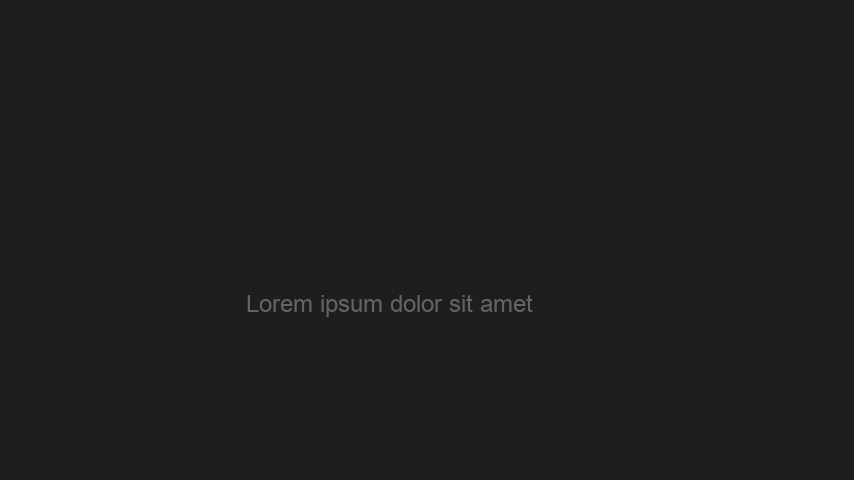

In [370]:
i += 1
Image.fromarray(vid[i])

In [43]:
import av
import numpy as np

frames = vid
height, width = frames.shape[1], frames.shape[2]
fps = 30

# Open output container
container = av.open('output.mp4', mode='w')

# Create a H.264 video stream
stream = container.add_stream('h264', rate=fps)
stream.width = width
stream.height = height
stream.pix_fmt = 'yuv420p'  # most compatible

for frame in frames:
    # Create a VideoFrame from the numpy array (RGB)
    video_frame = av.VideoFrame.from_ndarray(frame, format='rgb24')
    # Reformat to the stream's pixel format
    for packet in stream.encode(video_frame):
        container.mux(packet)

# Flush encoder
for packet in stream.encode():
    container.mux(packet)

# Close and write file
container.close()

print("Saved video as output.mp4")

Saved video as output.mp4


In [49]:
#!/usr/bin/env python3
"""
Video Duration Analyzer for GCS Action Capture Data

Counts video files for each user from the GCS structure:
gs://induction-labs/action_capture/<user>/<timestamp>/*.mp4
Each video is 30 seconds long.

Usage:
    python video_duration_analyzer.py
"""

from __future__ import annotations

from pathlib import Path

import gcsfs
import pandas as pd


class VideoDurationAnalyzer:
    VIDEO_DURATION_SECONDS = 30.0

    def __init__(self, bucket_path: str = "gs://induction-labs/action_capture/"):
        self.bucket_path = bucket_path
        self.fs = gcsfs.GCSFileSystem()

    def list_users(self) -> list[str]:
        """List all users in the action capture directory"""
        try:
            users = []
            for path in self.fs.ls(self.bucket_path.replace("gs://", "")):
                user = Path(path).name
                if user and not user.startswith("."):
                    users.append(user)
            return sorted(users)
        except Exception as e:
            print(f"Error listing users: {e}")
            return []

    def count_user_videos(self, user: str) -> dict[str, any]:
        """Count MP4 files for a specific user"""
        user_path = f"{self.bucket_path}{user}/"
        video_count = 0
        sessions = []

        try:
            user_path_clean = user_path.replace("gs://", "")
            for timestamp_dir in self.fs.ls(user_path_clean):
                timestamp = Path(timestamp_dir).name
                timestamp_path_clean = timestamp_dir

                session_videos = 0
                for file_path in self.fs.ls(timestamp_path_clean):
                    if file_path.endswith(".mp4"):
                        session_videos += 1
                        video_count += 1

                if session_videos > 0:
                    sessions.append(
                        {
                            "timestamp": timestamp,
                            "video_count": session_videos,
                            "duration_seconds": session_videos
                            * self.VIDEO_DURATION_SECONDS,
                        }
                    )

        except Exception as e:
            print(f"Error counting videos for user {user}: {e}")

        total_duration = video_count * self.VIDEO_DURATION_SECONDS

        return {
            "user": user,
            "total_videos": video_count,
            "total_sessions": len(sessions),
            "total_duration_seconds": total_duration,
            "total_duration_minutes": total_duration / 60,
            "total_duration_hours": total_duration / 3600,
            "sessions": sessions,
        }

    def analyze_all_users(self) -> dict[str, dict]:
        """Count video files for all users"""
        users = self.list_users()

        if not users:
            print("No users found in the bucket")
            return {}

        print(f"Found {len(users)} users: {', '.join(users)}")

        results = {}
        for user in users:
            print(f"Counting videos for user: {user}")
            results[user] = self.count_user_videos(user)

        return results

    def generate_summary_report(self, results: dict[str, dict]) -> pd.DataFrame:
        """Generate a summary report as a DataFrame"""
        summary_data = []

        for user, data in results.items():
            summary_data.append(
                {
                    "User": user,
                    "Total Videos": data["total_videos"],
                    "Total Sessions": data["total_sessions"],
                    "Total Duration (seconds)": int(data["total_duration_seconds"]),
                    "Total Duration (minutes)": round(
                        data["total_duration_minutes"], 1
                    ),
                    "Total Duration (hours)": round(data["total_duration_hours"], 2),
                    "Avg Videos per Session": round(
                        data["total_videos"] / data["total_sessions"], 1
                    )
                    if data["total_sessions"] > 0
                    else 0,
                }
            )

        return pd.DataFrame(summary_data)

    def save_detailed_report(
        self, results: dict[str, dict], filename: str = "video_duration_analysis.csv"
    ):
        """Save detailed per-session analysis to CSV"""
        detailed_data = []

        for user, data in results.items():
            for session in data["sessions"]:
                detailed_data.append(
                    {
                        "User": user,
                        "Session Timestamp": session["timestamp"],
                        "Video Count": session["video_count"],
                        "Duration (seconds)": int(session["duration_seconds"]),
                        "Duration (minutes)": round(
                            session["duration_seconds"] / 60, 1
                        ),
                    }
                )

        df = pd.DataFrame(detailed_data)
        return df


def main(path: str = "gs://induction-labs/action_capture/"):
    analyzer = VideoDurationAnalyzer(path)

    print("Starting video count analysis...")
    print("=" * 50)

    # Count videos for all users
    results = analyzer.analyze_all_users()

    if not results:
        print("No results to display")
        return

    # Generate and display summary
    print("\n" + "=" * 50)
    print("SUMMARY REPORT")
    print("=" * 50)

    summary_df = analyzer.generate_summary_report(results)
    print(summary_df.to_string(index=False))

    # Save detailed report
    print("\n" + "=" * 50)
    print("SAVING DETAILED REPORT")
    print("=" * 50)

    analyzer.save_detailed_report(results)

    # Overall statistics
    total_videos = summary_df["Total Videos"].sum()
    total_sessions = summary_df["Total Sessions"].sum()
    total_duration_hours = summary_df["Total Duration (hours)"].sum()

    print("\nOVERALL STATISTICS:")
    print(f"Total users: {len(results)}")
    print(f"Total sessions: {total_sessions}")
    print(f"Total videos: {total_videos}")
    print(f"Total duration: {total_duration_hours:.2f} hours")
    print(f"Average videos per user: {total_videos / len(results):.1f}")
    print(f"Average sessions per user: {total_sessions / len(results):.1f}")


main()

Starting video count analysis...
Found 2 users: jeffrey, jonathan
Counting videos for user: jeffrey
Counting videos for user: jonathan

SUMMARY REPORT
    User  Total Videos  Total Sessions  Total Duration (seconds)  Total Duration (minutes)  Total Duration (hours)  Avg Videos per Session
 jeffrey           739               7                     22170                     369.5                    6.16                   105.6
jonathan           405               9                     12150                     202.5                    3.38                    45.0

SAVING DETAILED REPORT

OVERALL STATISTICS:
Total users: 2
Total sessions: 16
Total videos: 1144
Total duration: 9.54 hours
Average videos per user: 572.0
Average sessions per user: 8.0


In [51]:
main("gs://induction-labs-data-ext/action_capture/")

Starting video count analysis...
Found 4 users: entropyboon, jeffrey, jonathan, jonathanwindows
Counting videos for user: entropyboon
Counting videos for user: jeffrey
Counting videos for user: jonathan
Counting videos for user: jonathanwindows

SUMMARY REPORT
           User  Total Videos  Total Sessions  Total Duration (seconds)  Total Duration (minutes)  Total Duration (hours)  Avg Videos per Session
    entropyboon             1               1                        30                       0.5                    0.01                     1.0
        jeffrey          1883              11                     56490                     941.5                   15.69                   171.2
       jonathan          1707              14                     51210                     853.5                   14.22                   121.9
jonathanwindows             5               2                       150                       2.5                    0.04                     2.5

SAVING D